In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from matplotlib import rcParams
from statsmodels.tsa import tsatools
from dmba import regressionSummary
from matplotlib.patches import Ellipse
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import date2num
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
# import pytabular as pytab
from statsmodels.graphics import tsaplots

no display found. Using non-interactive Agg backend


In [2]:
daily_peak_df=pd.read_excel('Data/niti/Daily_Peak_Demand7.xlsx',skipfooter=4)

daily_peak_df['Date']=pd.to_datetime(daily_peak_df['Date'],format='%d-%m-%Y')
daily_peak_ts=pd.Series(daily_peak_df['Peak Demand Met'].values,index=daily_peak_df['Date'],name='Daily_Peak')
daily_peak_ts.index=pd.DatetimeIndex(daily_peak_ts.index,freq='d')
daily_peak_df.dropna(inplace=True)
daily_peak_ts.dropna(inplace=True)

<bound method Axes.set of <Axes: xlabel='Date'>>

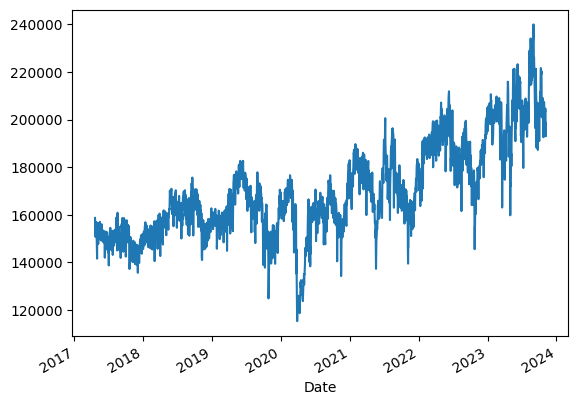

In [3]:
ax=daily_peak_ts.plot()
ax.set

In [4]:
daily_peak_ts.values

array([158628., 155542., 152714., ..., 201946., 192944., 198571.])

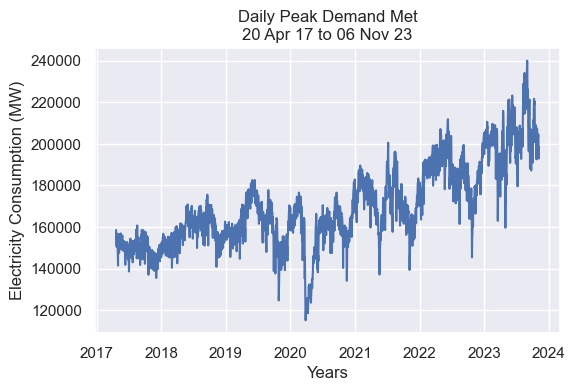

In [5]:
sns.set(style="darkgrid")
sns.lineplot(x=daily_peak_ts.index, y=daily_peak_ts.values, data=daily_peak_ts)
plt.xlabel("Years")
plt.ylabel("Electricity Consumption (MW)")
plt.title("Daily Peak Demand Met\n20 Apr 17 to 06 Nov 23")
fig_width = 6
fig_height = fig_width / 1.618  # Using the golden ratio, adjust as needed
fig_size = (fig_width, fig_height)
plt.gcf().set_size_inches(*fig_size)
plt.savefig('Data/images/Daily Peak.png',dpi=400,bbox_inches='tight')
plt.show()


/var/folders/nh/46bvkkfx38z0t75cg6clp_c00000gn/T/ipykernel_4044/2467469351.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


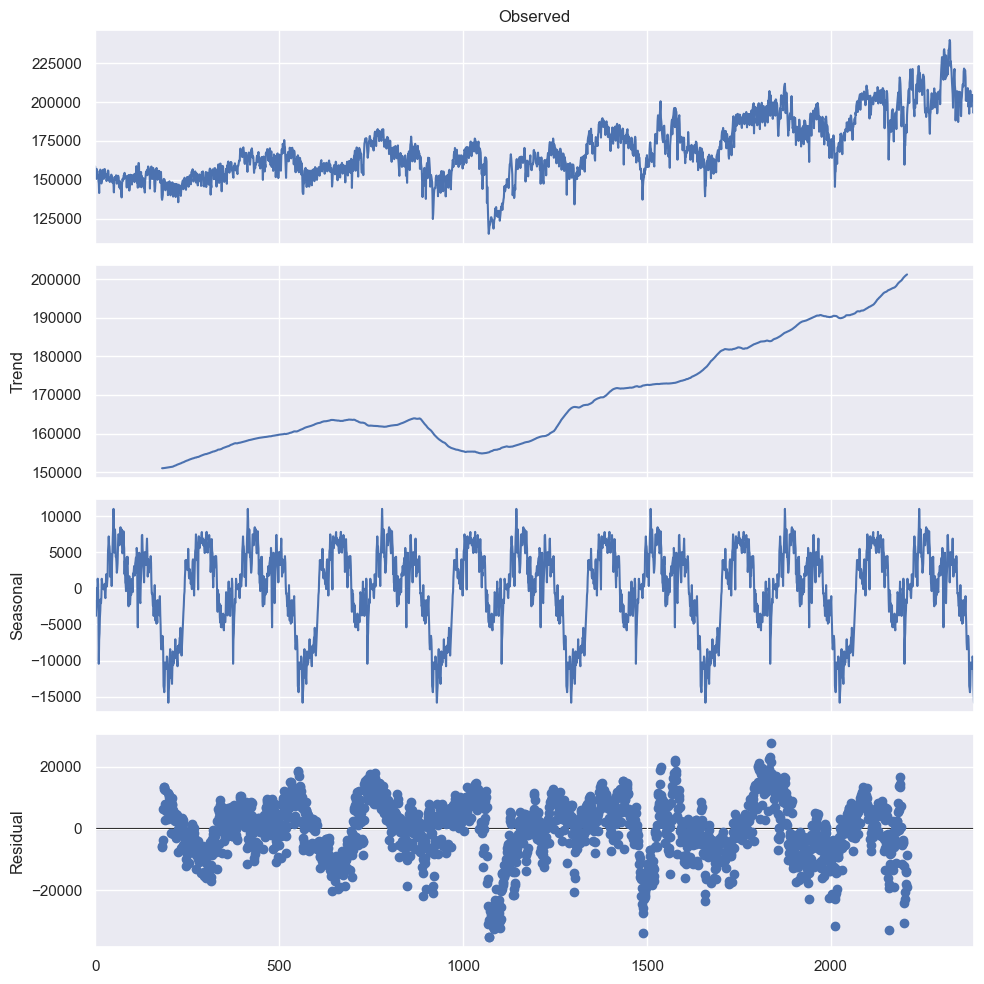

In [6]:
# Perform seasonal decomposition
result = seasonal_decompose(daily_peak_ts.values, model='additive', period=365)  # 'additive' or 'multiplicative'
# Fit a linear regression line to the trend component



plt.rcParams.update({'figure.figsize': (10,10)})
fig=result.plot()
# fig.axes[0].set_ylabel('Observed') # Label 1st subplot's y-axis.
# plt.xlabel('Year') 
plt.tight_layout()


# x_values = np.arange(len(result.trend))
# slope, intercept = np.polyfit(x_values, result.trend, 1)
# linear_fit = slope * x_values + intercept

# # Plot the original time series and the decomposed components
# plt.figure(figsize=(12, 8))


# plt.subplot(4, 1, 1)
# plt.plot(daily_peak_ts.values, label='Original Time Series')
# plt.ylabel('Orioginal Series')

# plt.subplot(4, 1, 2)
# lines,=plt.plot(result.trend, label='Trend')
# # plt.plot( linear_fit, label='Linear Fit', linestyle='--', color='red')
# plt.ylabel('Trend')
# xData=lines.get_ydata()

# plt.subplot(4, 1, 3)
# plt.plot(result.seasonal, label='Seasonality')
# plt.ylabel('Seasonality')

# plt.subplot(4, 1, 4)
# plt.plot(result.resid, label='Residuals')
# plt.ylabel('Residuals')

# # plt.tight_layout()
# plt.suptitle('Time series decomposition with yearly seasonality')



# plt.show()

In [7]:
daily_peak_df=pd.DataFrame(daily_peak_ts)
result = seasonal_decompose(daily_peak_ts.values, model='additive', period=365)  # 'additive' or 'multiplicative'
daily_peak_df['Trend']=result.trend
daily_peak_df['Seasonality']=result.seasonal
daily_peak_df['Residual']=result.resid


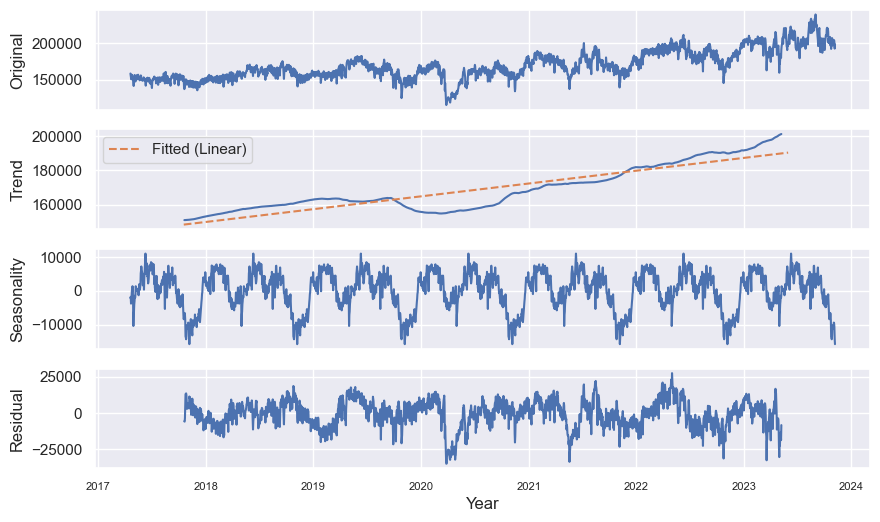

In [8]:
fig_width = 10
fig_height = fig_width/1.68   # Using the golden ratio, adjust as needed
fig_size = (fig_width, fig_height)
sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=fig_size, sharex=True)


sns.lineplot(x=daily_peak_ts.index, y=daily_peak_ts.values, data=daily_peak_ts,ax=axes[0])

valid_indices = np.isfinite(daily_peak_df['Trend']) 
slope,intercept = np.polyfit(np.arange(len(daily_peak_df.index))[valid_indices], daily_peak_df['Trend'][valid_indices], 1)
trend_yval=slope*np.arange(len(daily_peak_df.index))+intercept
mask =~((daily_peak_df.index >= daily_peak_df.index[180]) & (daily_peak_df.index <= daily_peak_df.index[-160]))
trend_yval[mask]=np.nan
# x_subset,y_subset=daily_peak_df.index[mask],daily_peak_df['Trend'][mask]
# sns.lineplot(x=x_subset, y=y_subset, data=daily_peak_df,ax=axes[1])
sns.lineplot(x=daily_peak_df.index, y=daily_peak_df['Trend'], data=daily_peak_df,ax=axes[1])
sns.lineplot(x=daily_peak_df.index, y=trend_yval,ax=axes[1],linestyle='dashed',legend='full',
            label='Fitted (Linear)')
for ax in axes.flatten():
     ax.tick_params(axis='x',  labelsize=8)                   
axes[0].set_ylabel('Original')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[3].set_xlabel('Year')

sns.lineplot(x=daily_peak_df.index, y=daily_peak_df['Seasonality'], data=daily_peak_df,ax=axes[2])

sns.lineplot(x=daily_peak_df.index, y=daily_peak_df['Residual'], data=daily_peak_df,ax=axes[3])
plt.savefig('Data/images/Decompose.png',dpi=400)
plt.show()

In [9]:
def singleGraphLayout(ax, ylim, train_df, valid_df):
#     ax.set_xlim('2017', '2023-6')
#     ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_df.index), max(train_df.index) - one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
#     ax.text('1995', ypos, 'Training')
#     ax.text('2002-3', ypos, 'Validation')
    
def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Daily_Peak', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Daily_Peak', ax=axes[0], color='C0', linestyle='dashed',
                  linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend():
        axes[0].get_legend().remove()


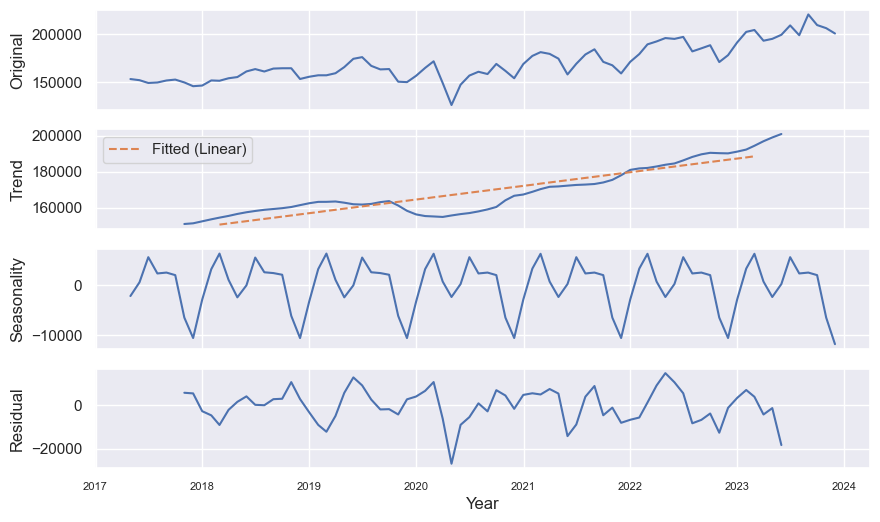

In [10]:
monthly_data = daily_peak_df.resample('M').mean()

fig_width = 10
fig_height = fig_width/1.68   # Using the golden ratio, adjust as needed
fig_size = (fig_width, fig_height)
sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=fig_size, sharex=True)


sns.lineplot(x=monthly_data.index, y=monthly_data['Daily_Peak'], data=monthly_data,ax=axes[0])

valid_indices = np.isfinite(monthly_data['Trend']) 
slope,intercept = np.polyfit(np.arange(len(monthly_data.index))[valid_indices], monthly_data['Trend'][valid_indices], 1)
trend_yval=slope*np.arange(len(monthly_data.index))+intercept
mask =~((monthly_data.index >= monthly_data.index[10]) & (monthly_data.index <= monthly_data.index[-10]))
trend_yval[mask]=np.nan
# x_subset,y_subset=daily_peak_df.index[mask],daily_peak_df['Trend'][mask]
# sns.lineplot(x=x_subset, y=y_subset, data=daily_peak_df,ax=axes[1])
sns.lineplot(x=monthly_data.index, y=monthly_data['Trend'], data=monthly_data,ax=axes[1])
sns.lineplot(x=monthly_data.index, y=trend_yval,ax=axes[1],linestyle='dashed',legend='full',
            label='Fitted (Linear)')
for ax in axes.flatten():
     ax.tick_params(axis='x',  labelsize=8)                   
axes[0].set_ylabel('Original')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[3].set_xlabel('Year')

sns.lineplot(x=monthly_data.index, y=monthly_data['Seasonality'], data=monthly_data,ax=axes[2])

sns.lineplot(x=monthly_data.index, y=monthly_data['Residual'], data=monthly_data,ax=axes[3])
plt.savefig('Data/images/Decompose_monthly.png',dpi=400)
plt.show()



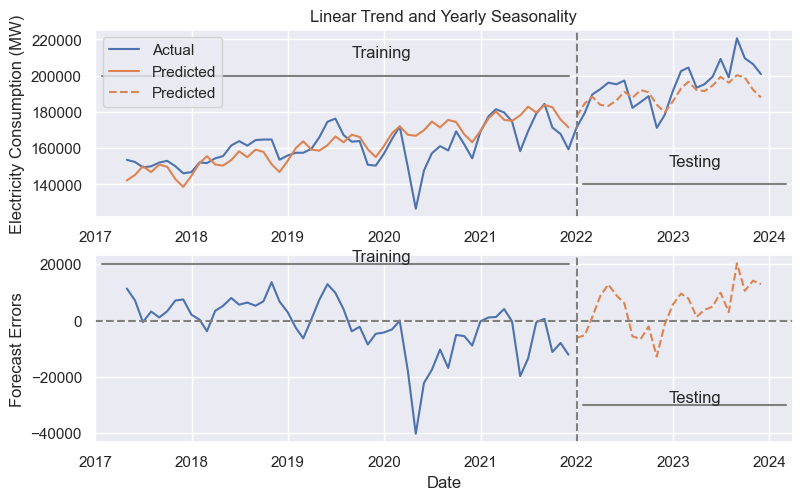

In [11]:
monthly_data = daily_peak_df.resample('M').mean()
monthly_data=tsatools.add_trend(monthly_data['Daily_Peak'],trend='ct')
monthly_data['Month']=monthly_data.index.month
dummy_categories = (pd.get_dummies(monthly_data['Month'], prefix='Month',drop_first=True)).astype(int)
monthly_data = pd.concat([monthly_data, dummy_categories], axis=1)

nValid=24
nTrain=len(monthly_data)-nValid
train_df=monthly_data[:nTrain]
test_df=monthly_data[nTrain:]
X = sm.add_constant(monthly_data[['const','trend','Month_2','Month_3','Month_4','Month_5','Month_6',
                                  'Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']])
# X = sm.add_constant(monthly_data[['const','trend','Month_2']])
monthly_lm_sea = sm.OLS(monthly_data['Daily_Peak'],X).fit()

col_remove=['Month','Daily_Peak']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 9/1.68))

sns.lineplot(x=monthly_data.index, y=monthly_data['Daily_Peak'],
             ax=axes[0],label='Actual')
sns.lineplot(x=monthly_data.index[:nTrain], y=monthly_lm_sea.predict(train_df.drop(columns=col_remove)),
             ax=axes[0],label='Predicted')
sns.lineplot(x=monthly_data.index[nTrain:], y=monthly_lm_sea.predict(test_df.drop(columns=col_remove)),
             ax=axes[0],color='C1', linestyle='dashed',label='Predicted')
axes[0].axvline(x=monthly_data.index[nTrain], color='grey', linestyle='--')
xmax=date2num(monthly_data.index[nTrain])/date2num(monthly_data.index[-1])
axes[0].axhline(y=200000, color='grey', linestyle='-',xmax=.68,xmin=.01)
axes[0].text(18139.0, 210000, 'Training')

axes[0].axhline(140000, color='grey', linestyle='-', xmax=.99,xmin=.70)
axes[0].text(19341.5, 150000, 'Testing')
axes[0].set_ylabel('Electricity Consumption (MW)')
axes[0].set_xlabel('')
axes[0].set_title('Linear Trend and Yearly Seasonality')
axes[0].legend()

# sns.lineplot(x=monthly_data.index, y=monthly_data['Daily_Peak'],
#              ax=axes[0])
residual = train_df['Daily_Peak'] - monthly_lm_sea.predict(train_df.drop(columns=col_remove))

sns.lineplot(x=monthly_data.index[:nTrain], y=residual,
             ax=axes[1])

residual = test_df['Daily_Peak'] - monthly_lm_sea.predict(test_df.drop(columns=col_remove))
sns.lineplot(x=monthly_data.index[nTrain:], y=residual,
             ax=axes[1],color='C1', linestyle='dashed')
axes[1].axvline(x=monthly_data.index[nTrain], color='grey', linestyle='--')
xmax=date2num(monthly_data.index[nTrain])/date2num(monthly_data.index[-1])
axes[1].axhline(y=20000, color='grey', linestyle='-', 
                xmax=.68,xmin=.01)
axes[1].text(18139.0, 21000, 'Training')

axes[1].axhline(-30000, color='grey', linestyle='-',
                xmax=.99,xmin=.70)
axes[1].text(19341.5, -29000, 'Testing')


axes[1].set_ylabel('Forecast Errors')

axes[1].axhline(0.0, color='grey', linestyle='--')

plt.savefig('Data/images/Monthly_test_train.png',dpi=400)
plt.show()

In [12]:
#errors

#train
predictions_train=monthly_lm_sea.predict(train_df.drop(columns=col_remove))
y_train=train_df['Daily_Peak']

mae_train = round(mean_absolute_error(y_train, predictions_train),2)
mape_train = round(mean_absolute_percentage_error(y_train, predictions_train),2)
rmse_train = round(np.sqrt(mean_squared_error(y_train, predictions_train)),2)

#test

predictions_test=monthly_lm_sea.predict(test_df.drop(columns=col_remove))
y_test=test_df['Daily_Peak']

mae_test = round(mean_absolute_error(y_test, predictions_test),2)
mape_test = round(mean_absolute_percentage_error(y_test, predictions_test),2)
rmse_test = round(np.sqrt(mean_squared_error(y_test, predictions_test)),2)

# make latex table

data = {
    ('', 'Measure'): ['MAE', 'MAPE', 'RMSE'],
    ('OLS', 'Test'): [mae_train, mape_train, rmse_train],
    ('OLS', 'Train'): [mae_test, mape_test, rmse_test]
}
df = pd.DataFrame(data)
latex_table=df.to_latex(index=False, multirow=True, multicolumn=True)

print(latex_table)


\begin{tabular}{lrr}
\toprule
 & \multicolumn{2}{r}{OLS} \\
Measure & Test & Train \\
\midrule
MAE & 7129.320000 & 7576.000000 \\
MAPE & 0.050000 & 0.040000 \\
RMSE & 9948.140000 & 8894.580000 \\
\bottomrule
\end{tabular}



Text(0.5, 1.0, 'PACF - Residual')

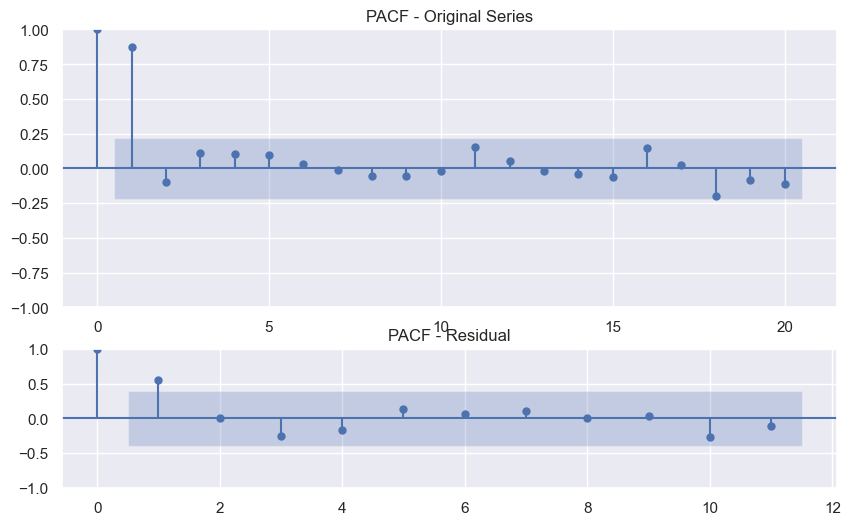

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10/1.68),gridspec_kw={'height_ratios': [2, 1]})
# tsaplots.plot_acf(monthly_data['Daily_Peak'],ax=axes)
fig=tsaplots.plot_pacf(monthly_data['Daily_Peak'],ax=axes[0])
axes[0].set_title ('PACF - Original Series')
fig=tsaplots.plot_pacf(residual,ax=axes[1],lags=11)
axes[1].set_title ('PACF - Residual')

# fig.savefig('Data/images/Pacf_.png',dpi=400)

24

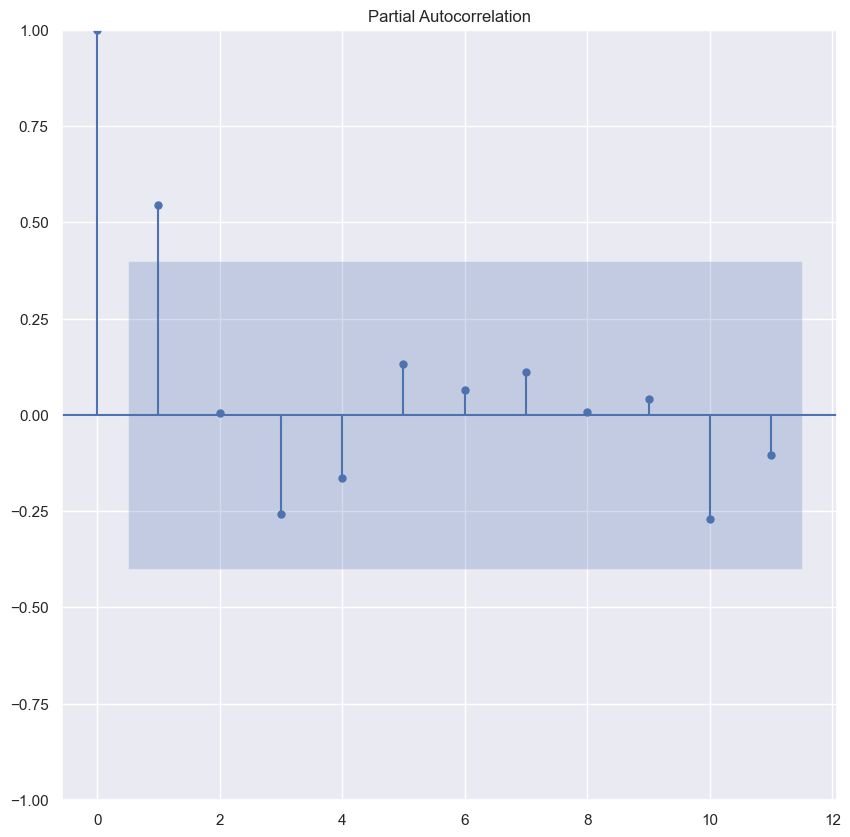

In [23]:
tsaplots.plot_pacf(residual,lags=11)
len(residual)

In [ ]:
data = {
    'Name': ['Alice', 'Bob', 'Charlie', 'David'],
    'Age': [25, 30, 35, 40],
    'Salary': [50000, 60000, 75000, 90000]
}

df = pd.DataFrame(data)

# Create a figure and axis
fig, ax = plt.subplots()

# Hide the axes
ax.axis('off')

# Create a table and add it to the figure
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Set the font size of the table
table.auto_set_font_size(False)
table.set_fontsize(12)

# Adjust the layout
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
# # create short time series from 1997 to 1999 using a slice
daily_peak_ts_3yrs = daily_peak_ts['2018':'2019']
# # create a data frame with additional predictors from time series
# # the following command adds a constant term, a trend term and a quadratic trend term
daily_peak_df = tsatools.add_trend(daily_peak_ts, trend='ctt')
# # fit a linear regression model to the time series
X = sm.add_constant(daily_peak_df[['const','trend', 'trend_squared']])
daily_peak_lm = sm.OLS(daily_peak_df['Daily_Peak'],X).fit()

# # shorter and longer time series
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
# daily_peak_ts_3yrs.plot(ax=axes[0])
# daily_peak_ts.plot(ax=axes[1])
# for ax in axes:
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Ridership (in 000s)')
# #     ax.set_ylim(1300, 2300)
# daily_peak_lm.predict(X).plot(ax=axes[1])
# plt.show()

sns.set(style="darkgrid")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

sns.lineplot(x=daily_peak_ts_3yrs.index, y=daily_peak_ts_3yrs.values, data=daily_peak_ts_3yrs,ax=axes[0])
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Electricity Consumption")
axes[0].set_title("Plot of electricity consumption")


sns.lineplot(x=daily_peak_ts.index, y=daily_peak_ts.values, data=daily_peak_ts,ax=axes[1])
sns.lineplot(x=daily_peak_lm.predict(X).index, y=daily_peak_lm.predict(X).values)
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Electricity Consumption")
axes[1].set_title("Plot of electricity consumption")



In [ ]:
# Data Partitioning and performance evaluation
daily_peak_ts_valid = daily_peak_ts['2022':'2024']
nValid = len(daily_peak_ts_valid)
nTrain = len(daily_peak_ts) - nValid
# partition the data
train_ts = daily_peak_ts[:nTrain]
valid_ts = daily_peak_ts[nTrain:]
naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)
last_season=train_ts[-365:]
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values,
                          index=valid_ts.index)

In [ ]:
# plot forecasts and actual in the training and validation sets
ax = train_ts.plot(color='C0', linewidth=0.75, figsize=(9,7))
valid_ts.plot(ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
# ax.set_xlim('1990', '2006-6')
# ax.set_ylim(1300, 2600)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
naive_pred.plot(ax=ax, color='green')
seasonal_pred.plot(ax=ax, color='orange')


In [ ]:
regressionSummary(valid_ts, naive_pred)
regressionSummary(valid_ts, seasonal_pred)

# Regression-Based Forecasting

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots


# Linear Trend

In [ ]:
daily_peak_df=pd.read_excel('Data/niti/Daily_Peak_Demand7.xlsx',skipfooter=4)

daily_peak_df['Date']=pd.to_datetime(daily_peak_df['Date'],format='%d-%m-%Y')
daily_peak_ts=pd.Series(daily_peak_df['Peak Demand Met'].values,index=daily_peak_df['Date'],name='Daily_Peak')
daily_peak_ts.index=pd.DatetimeIndex(daily_peak_ts.index,freq='d')
daily_peak_df.dropna(inplace=True)
daily_peak_ts.dropna(inplace=True)

# # create a data frame with additional predictors from time series
# # the following command adds a constant term, a trend term and a quadratic trend term
daily_peak_df = tsatools.add_trend(daily_peak_ts, trend='ct')
# # fit a linear regression model to the time series
X = sm.add_constant(daily_peak_df[['const','trend']])
daily_peak_lm = sm.OLS(daily_peak_df['Daily_Peak'],X).fit()

# shorter and longer time series
ax = daily_peak_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
daily_peak_lm.predict(X).plot(ax=ax)
plt.show()

In [ ]:
ridership_df

In [ ]:
# load data and convert to time series
Amtrak_df = pd.read_csv('D:EPABA/Python/book/dmba/Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date,name='Ridership')
# fit a linear trend model to the time series
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
X = sm.add_constant(ridership_df[['const','trend']])
# ridership_lm = sm.ols(formula='Ridership ~ trend', data=ridership_df).fit()
ridership_lm = sm.OLS(ridership_df['Ridership'],X).fit()

# shorter and longer time series
ax = ridership_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ridership_lm.predict(X).plot(ax=ax)
plt.show()

In [ ]:
ridership_df

In [ ]:
nValid = 36
nTrain = len(ridership_ts) - nValid
# partition the data
train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]
naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)
last_season = train_ts[-12:]
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values,
                          index=valid_ts.index)

In [ ]:
train_ts

In [ ]:
valid_ts

In [ ]:
last_season

In [ ]:
ridership_ts

In [ ]:
pd.concat([last_season]*5)[:len(valid_ts)]

In [ ]:
daily_peak_ts_3yrs

In [ ]:
daily_peak_ts